In [1]:
import numpy as np

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
from l5kit.rasterization import build_rasterizer

import os
import copy
from itertools import cycle, combinations

import sys
sys.path.append('../..')

import backpack

In [2]:
os.environ['L5KIT_DATA_FOLDER'] = '../../dataset'
dm = LocalDataManager(None)

cfg = load_config_data('./config.yaml')
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}


In [3]:
train_cfg = cfg['train_data_loader']
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg['key'])).open()

In [4]:
def map_frame_array_to_dict(array):
    return dict(zip(['timestamp', 'agent_index_interval', 'ego_rotation', 'ego_translation'], array))

def map_scene_array_to_dict(array):
    return dict(zip(['frame_index_interval', 'host', 'start_time', 'end_time'], array))

def map_agent_array_to_dict(array):
    return dict(zip(['centroid', 'extent', 'yaw', 'velocity', 'track_id', 'label_probabilities'], array))

In [5]:
scenes = [map_scene_array_to_dict(s) for s in train_zarr.scenes]
frames = [map_frame_array_to_dict(f) for f in train_zarr.frames]
agents = [map_agent_array_to_dict(a) for a in train_zarr.agents]

In [6]:
# playing around with scene 85
scene_i = 99
scene = scenes[scene_i]
scene

{'frame_index_interval': array([24590, 24838]),
 'host': 'host-a101',
 'start_time': 1571844710505151232,
 'end_time': 1571844735505151232}

In [7]:
clusters = []

fii = scene['frame_index_interval']
for frame in frames[fii[0]: fii[1]]:
    
    c = backpack.Cluster(frame, agents)
    c.normalize_data()

    clusters.append(c)

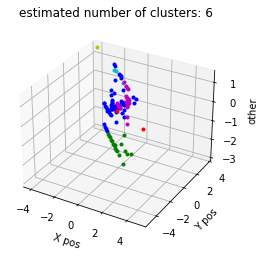

In [8]:
clusters[99].agglomerative_cluster(n_clusters=6)
clusters[99].plot(other=4)
clusters[99].generate_distance_matrices()
clusters[99].generate_relative_motion_matrices()
clusters[99].generate_average_relative_motions();

In [9]:
frame

{'timestamp': 1571844735402847046,
 'agent_index_interval': array([1893690, 1893736]),
 'ego_rotation': array([315990, 316008]),
 'ego_translation': array([277.59915161,  38.03862   , 269.53125   ])}

In [10]:
# clusters[99].average_relative_motions

In [11]:
FRAME_DURATION = 0.1  # in seconds
angle_between = lambda u, v: np.arccos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)))

In [12]:
class AngularSpeedComputer:
    def __init__(self, scene, frames, agents, window=10):
        self._fii = scene['frame_index_interval']
        self._frames = frames
        self._agents = agents
        self._window = window
        
        # map_ftiti is map frame, track id to index
        # maybe don't name it so strangly
        self._max_track_id, self._map_ftiti = self._extract_track_ids()
                
        self._moving_angular_speeds = [self._compute_moving_angular_speed(tid)
                                       for tid in range(*[1, self._max_track_id + 1])]
    
    @property
    def moving_angular_speeds(self):
        return self._moving_angular_speeds
    
    def change_window_and_recompute(self, window=10):
        self._window = window 
        self._moving_angular_speed = [self._compute_moving_angular_speed(tid)
                                      for tid in range(*[1, self._max_track_id + 1])]
    
    def _extract_track_ids(self):
        max_track_id = 0
        map_frame_track_id_to_index = dict()
        
        for frame_i in range(*self._fii):
            if frame_i not in map_frame_track_id_to_index:
                map_frame_track_id_to_index[frame_i] = dict()
            
            frame = self._frames[frame_i]
            aii = frame['agent_index_interval']
            
            for agent_i in range(*aii):
                agent = self._agents[agent_i]
                
                map_frame_track_id_to_index[frame_i][agent['track_id']] = agent_i
                
                if agent['track_id'] > max_track_id:
                    max_track_id = agent['track_id']
        
        return int(max_track_id), map_frame_track_id_to_index
    
    def _compute_moving_angular_speed(self, track_id):
        # compute angular momentum with self._window sized window
        # max window to compute on is 100 - self._window
        return [self._compute_average_angular_speed(track_id=track_id, start_frame_id=sfi)
                for sfi in range(100 - self._window)]
    
    def _compute_average_angular_speed(self, track_id, start_frame_id):
        position = self._make_position_retriever(track_id, start_frame_id)
        
        positions = [position(i) for i in range(self._window)]
        deltas = [positions[i + 1] - positions[i] for i in range(len(positions) - 1)]
        thetas = [angle_between(deltas[i + 1], deltas[i]) for i in range(len(deltas) - 1)]
        
        avg_theta = np.mean(thetas)
        
        # in revolutions per second
        angular_speed = FRAME_DURATION * 2 * np.pi / avg_theta
        
        return angular_speed
            
            
    def _make_position_retriever(self, track_id, start_frame_id):
        def position(i):
            frame_i = self._fii[0] + start_frame_id + i
            
            # if it is not in the frame, then we do not consider it and return NaN
            if track_id not in self._map_ftiti[frame_i]:
                return np.NaN
            
            agent_i = self._map_ftiti[self._fii[0] + start_frame_id + i][track_id]
            return self._agents[agent_i]['centroid']
        
        return position

In [13]:
fii = scene['frame_index_interval']
aii = frames[fii[0]]['agent_index_interval']

In [14]:
import matplotlib.pyplot as plt

In [15]:
amc = AngularSpeedComputer(scene, frames, agents)

/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


[0.5586264455217073, 0.6276006521608841, 0.6401919588435756, 0.7655594707792306, 0.6877594261576676, 0.678600744912825, 0.6776731397272932, 0.5966624050133226, 0.617995858022584, 0.49957447189024107, 0.4059785312074646, 0.3411228258643725, 0.37171050198835964, 0.4696706049853825, 0.37113267686939133, 0.3903373004309428, 0.3884126370958748, 0.41559973641979014, 0.5239797125939333, 0.5095419612168375, 0.49954553589073747, 0.4717204469276084, 0.6292859331970969, 0.5962969655378292, 0.73499978565369, 0.9295089428592952]


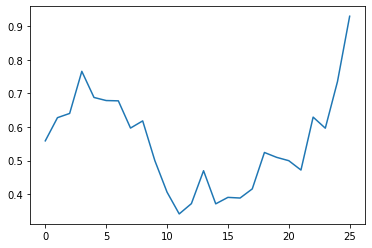

In [16]:
speeds = amc.moving_angular_speeds[1]

# ensure that speeds is a float that exists (not an array -- figure out whyt arrays are made in some cases)
speeds = list(filter(lambda x: (isinstance(x, np.float64) and not np.isnan(x)), speeds))

print(speeds)

plt.plot(list(range(len(speeds))), speeds)

In [17]:
x = [[4.0, 0.0], [3.980016661112103, 0.3993336665873126], [3.9202663113649665, 0.7946773231802449], [3.821345956502424, 1.1820808266453584], [3.6842439760115404, 1.557673369234602], [3.510330247561491, 1.917702154416812], [3.301342459638713, 2.258569893580142], [3.0593687491379535, 2.5768707489507645], [2.786826837388662, 2.869424363598091], [2.486439873082658, 3.133307638509933]]

for i in range(len(x)):
    x[i] = np.asarray(x[i])
x

[array([4., 0.]),
 array([3.98001666, 0.39933367]),
 array([3.92026631, 0.79467732]),
 array([3.82134596, 1.18208083]),
 array([3.68424398, 1.55767337]),
 array([3.51033025, 1.91770215]),
 array([3.30134246, 2.25856989]),
 array([3.05936875, 2.57687075]),
 array([2.78682684, 2.86942436]),
 array([2.48643987, 3.13330764])]

In [18]:
deltas = []

for i in range(len(x) - 1):
    deltas.append(x[i + 1] - x[i])

deltas

[array([-0.01998334,  0.39933367]),
 array([-0.05975035,  0.39534366]),
 array([-0.09892035,  0.3874035 ]),
 array([-0.13710198,  0.37559254]),
 array([-0.17391373,  0.36002879]),
 array([-0.20898779,  0.34086774]),
 array([-0.24197371,  0.31830086]),
 array([-0.27254191,  0.29255361]),
 array([-0.30038696,  0.26388327])]

In [19]:
compute_theta = lambda u, v: np.arccos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)))

thetas = []

for i in range(len(x) - 2):
    thetas.append(compute_theta(deltas[i+1], deltas[i]))

thetas

[0.09999999999999723,
 0.10000000000000057,
 0.09999999999999945,
 0.10000000000000057,
 0.09999999999999945,
 0.09999999999999945,
 0.09999999999999945,
 0.10000000000000057]

In [20]:
avg_t = np.mean(thetas)

0.1 * 2 * np.pi / avg_t

6.283185307179612